In [6]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
# use_existing_client='tcp://127.0.0.1:42761'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [7]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM     

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path     = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/dart/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path          = None #'~/figures/test_papermill/'
save_fname         = None # filename from papermill come in through save_fname
tripyrun_name      = None # papermill workflow name of notebook 
tripyrun_analysis  = None # papermill diagnostic driver
tripyrun_spath_nb  = None # papermill path to processed notebooks
tripyrun_spath_fig = None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')
# input_names.append('dart test') 

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None 
do_allcycl= True 
vname     = 'gzhflx'
year      = [1958,1961]
mon       = None
day       = None
record    = None 
box       = None
depth     = None
do_lonlat = 'lon'
dlonlat   = 1.0

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Boxregion via shape file for index compuation______________________________
box_region = list()
box_region.append('global')
box_region.append('moc_basins/Atlantic_MOC.shp')
box_region.append('moc_basins/IndoPacific_MOC.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('ocean_basins/Pacific_Basin.shp')

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 1      # number of pannel columns in figure
nrow              = 1
plt_opt           = dict({'marker':'o'})
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
save_dpi          = 300
save_fmt          = ['png']

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None

In [8]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem,
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Dask client already running: <Client: 'tcp://127.0.0.1:34165' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: //proxy/8787/status,
Dashboard: //proxy/8787/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34165,Workers: 32
Dashboard: //proxy/8787/status,Total threads: 64
Started: 3 minutes ago,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:45235,Total threads: 2
Dashboard: //proxy/35521/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:41687,


In [9]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
        
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)

#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# set predefined chunks size here! The optimized worker memory dependent chunk size is computed internally. 
# see def compute_optimal_chunks(path, client=None, varname=None, opti_dim='h', opti_chunkfrac=0.10):
# The here presetted values are used when tpv.load_data_fesom2( ..., opti_dim=None', ...), otherwise the 
# chunks are choosen to be not larger than 10% of the worker memory tpv.load_data_fesom2( ..., 
# opti_dim='hori', opti_chunkfrax=0.1, ...). Optimized can be the horizontal, vertical or time 
# dimension opti_dim: 'h', 'v', 'hv', 'vh', 't', 'off', None
chunks = dict({
               'elem' : 'auto', 'nod2' : 'auto', 'edg_n': 'auto',
               'nz1'  : 'auto', 'nz'   : 'auto', 
               'time' : 'auto', 
               }) 

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_mesh_core2_srt_dep@node_focus0.jlib
 > comp. e_resol from triangle height
 > comp n_resol from 2*sqrt(n_area/pi)
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
global
/albedo/home/pscholz/tripyview/tripyview moc_basins/Atlantic_MOC.shp
/albedo/home/pscholz/tripyview/tripyview moc_basins/IndoPacific_MOC.shp


In [12]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)

#___LOAD FESOM2 DATA___________________________________________________________________________________    
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # input parameter shortcut
    input_dict = dict({'year':year, 'mon':mon, 'descript':descript, 
                       'do_tarithm':'mean', # do time mean 
                       'chunks':chunks, 'do_load':False, 'do_persist':False, 'do_parallel':do_parallel, 
                       'client':client, 'opti_dim':'h' , 'opti_chunkfrac':0.06,
                       'do_info':False,})
    
    #__________________________________________________________________________________________________
    # load data
    data = tpv.load_data_fesom2(mesh, datapath, vname='fh', **input_dict)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load, fh data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    
    #__________________________________________________________________________________________________
    # compute meridional heat flux from surface heatflux fh by binning
    ts = clock.time()
    # data_list.append(tpv.calc_gmhflx_box(mesh, data, box, dlat=1.0, do_info=False, do_parallel=do_parallel, 
    #                                      n_workers=128-parallel_nprc))
    data_list.append(tpv.calc_gzmhflx_box_dask(mesh, data, box, do_parallel, parallel_nprc, 
                                               do_lonlat=do_lonlat, dlonlat=dlonlat, do_info=False, ))
    print(' --> elasped time to comp. global. merid. Hflux: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    del(data)
print(' --> total elasped time: {:3.2f} min.'.format( (clock.time()-t0)/60  ))     

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load, fh data: 0.01 min.
 --> data uses 0.00 Gb:
 --> nchunk= 1
 --> rechunk array size --> nchunk_new= 64
 --> nchunk= 1
 --> rechunk array size --> nchunk_new= 64
 --> nchunk= 1
 --> rechunk array size --> nchunk_new= 64
 --> elasped time to comp. global. merid. Hflux: 0.09 min.
 --> total elasped time: 0.10 min.


1 1


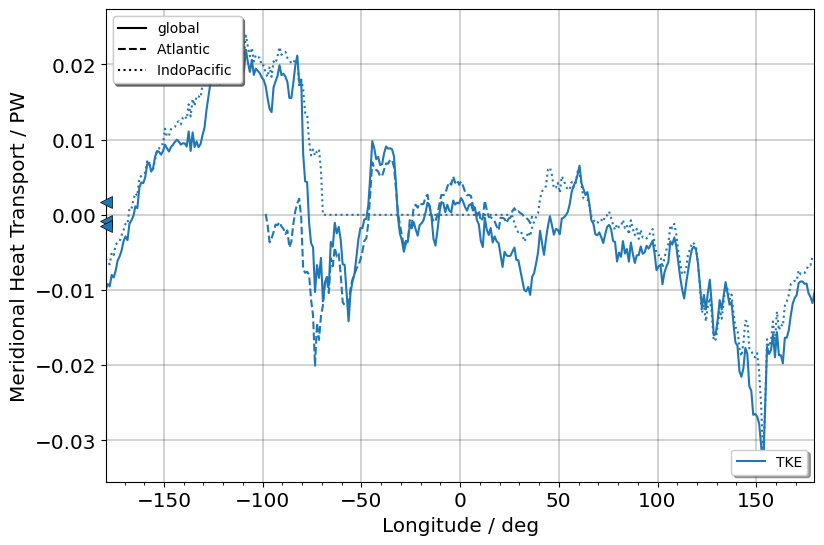

 --> elasped time to plot data: 0.01 min.


In [13]:
ts = clock.time()
nbox = len(box)
if   ncol != None: 
    ncol0  = np.min([ncol, nbox])    
    nrow0  = np.ceil(nbox/ncol0).astype('int')
    if nrow != None: nrow0=nrow 
elif nrow != None: 
    nrow0  = np.min([nrow, nbox])    
    ncol0  = np.ceil(nbox/nrow0).astype('int') 
    
svname = list(data_list[0][0].data_vars)[0]
slabel = data_list[0][0][svname].attrs['str_lsave']
sbox   = data_list[0][0][svname].attrs['boxname'].replace(' ','_').lower()
print(nrow0, ncol0)
#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, 'hline' ,slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#__________________________________________________________________________________________________
hfig, hax = tpv.plot_hline(data_list           , 
                    box        = box           , 
                    box_idx    = None          ,
                    boxl_opt   = dict()        , # option for box label string 
                    nrow       = nrow0         , # number of row in figures panel
                    ncol       = ncol0         ,
                    ax_opt=dict({'fig_sizefac':3,}),
                    do_allcycl = do_allcycl    ,   
                    n_cycl     = n_cycl        ,
                    do_enum    = do_enum       ,
                    do_shdw    = do_shdw       ,
                    do_mean    = do_mean       ,
                    do_save    = sfpath, save_dpi=save_dpi, 
                    ) 

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

In [ ]:
if do_papermill and do_parallel and client is not None: client.shutdown()